In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

import seaborn as sns
sns.set()

Using TensorFlow backend.


# Data 

In [2]:
data = pd.read_csv('D:/IITM/DeepCache/synthetic dataset/syntheticDataset_O50.csv')
data.head()

,object_ID,request_time
0,5,2.961472
1,25,3.274127
2,2,3.785475
3,2,4.455687
4,4,5.288994


In [130]:
data = np.array(data)
req = data[:,0]

len(req)

292146

In [4]:
# to find the probability of occurrence of Oi object is caculated as Ni/1000
# where Ni is number of occurrence of Oi in past 1k req

count = np.zeros(50)
for i in range(1000):
    for j in range(50):
        if req[i] == j+1:
            count[j] += 1

prob = []            
for i in range(1000,len(req)):
    t = int(req[i] - 1)
    count[t] += 1
    t = int(req[i-1000] - 1)
    count[t] -= 1
    prob.append(count/1000)

prob = np.array(prob)
prob.shape

(291146, 50)

In [5]:
encoder_input_data = prob[:250000,:].reshape(20,-1,50) # total samples = 20
batch_size = 12500
decoder_target_data = []
for i in range(1,21):
    temp = []
    for j in range(10): # to predict next 10 req for every batch
        temp.append(prob[(batch_size*i) + j,:])
    decoder_target_data.append(temp)    

decoder_target_data = np.array(decoder_target_data).reshape(20,10,-1)

print(encoder_input_data.shape,decoder_target_data.shape)

(20, 12500, 50) (20, 10, 50)


In [6]:
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[1:,:,:] = decoder_target_data[:-1,:,:]
decoder_input_data[0,:,:] = encoder_input_data[-1,-1,:]
decoder_input_data.shape

(20, 10, 50)

# Model

In [9]:
latent_dim = 128 # LSTM hidden units
dropout = 0.1

In [10]:
encoder_inputs = Input(shape=(None, 50)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
decoder_inputs = Input(shape=(None, 50)) 
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)


In [12]:
#decoder_dense = Dense(decoder_outputs) # 1 continuous output at each timestep
decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)


In [13]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [14]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 91648       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  91648       input_3[0][0]                    
                                                                 lstm_1[0][1]                     
          

# Compile The Model

In [15]:
model.compile(Adam(), loss='mean_squared_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=30)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
20/20 [==============================] - 36s 2s/step - loss: 9.4732e-04
Epoch 2/30
20/20 [==============================] - 29s 1s/step - loss: 9.4661e-04
Epoch 3/30
20/20 [==============================] - 30s 1s/step - loss: 9.4569e-04
Epoch 4/30
20/20 [==============================] - 29s 1s/step - loss: 9.4550e-04
Epoch 5/30
20/20 [==============================] - 30s 1s/step - loss: 9.4427e-04
Epoch 6/30
20/20 [==============================] - 31s 2s/step - loss: 9.4362e-04
Epoch 7/30
20/20 [==============================] - 30s 2s/step - loss: 9.4274e-04
Epoch 8/30
20/20 [==============================] - 41s 2s/step - loss: 9.4156e-04
Epoch 9/30
20/20 [==============================] - 34s 2s/step - loss: 9.4062e-04
Epoch 10/30
20/20 [==============================] - 33s 2s/step - loss: 9.3930e-04
Epoch 11/30
20/20 [==============================] - 31s 2s/step - loss: 

# Testing The Model 

In [22]:
encoder_model = Model(encoder_inputs, encoder_states)
pred_steps = 10

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [23]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 50))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, :] = input_seq[0, -1, :]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,50))
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,:] = output[0,0,:]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 50))
        target_seq[0, 0, :] = output[0,0,:]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [24]:
def request(prob):
    for i in range(50):
        if prob[i] == np.max(prob):
            return i+1

# fake request generation

In [95]:
len(prob)/1000

291.146

In [194]:
fake = []
for i in range(290):
    temp = []
    x = prob[i*1000:(i+1)*1000].reshape(1000,1,50)
    p = decode_sequence(x)
    for j in range(10):
        for k in range(50):
            if p[0,j,k] > sorted(p[0,j],reverse = 1)[5]:
                temp.append(k)
    fake.append(temp)            

In [195]:
fake = np.array(fake)
fake.shape

(290, 50)

In [196]:
request = []
for i in range(290):
    for j in range(1050):
        if j< 1000:
            request.append(req)
        else:
            request.append(fake[i][j-1000])
request = np.array(request).reshape(-1,1)           
request.shape

(304500, 1)

# LRU Caching

In [273]:
import time
import urllib
import urllib.request
from functools import lru_cache
@lru_cache(maxsize=5)
def get_url(resource):
    try:
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False

In [274]:
hit_LRU = np.zeros(len(req))
for i in range(len(req)):
    get_url(req[i])
    hit_LRU[i] = get_url.cache_info().hits
hit_LRU[1000]  

209.0

In [275]:
import time
import urllib
import urllib.request
from functools import lru_cache
@lru_cache(maxsize=5)
def get_url(resource):
    try:
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False

In [280]:
hit_deepcache = np.zeros(len(req))
for i in range(len(request)):
    get_url(request[i])
    hit_LRU[i] = (get_url.cache_info().hits)
hit_deepcache[1000]  

TypeError: unhashable type: 'numpy.ndarray'

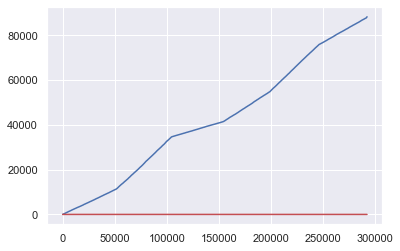

In [278]:
plt.plot(hit_LRU,'b')
plt.plot(hit_deepcache,'r')